In [1]:
import pickle
import os

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

### Download data

Go to https://www.cs.toronto.edu/~kriz/cifar.html and download the python version of the cifar dataset.
You should be able to read the data with the function below

In [3]:
notebook_path = os.path.abspath("A3.ipynb")
folder = os.path.join(os.path.dirname(notebook_path), "cifar-10-batches-py")

# file paths
train_val_data = []
test_data = None
for fname in os.listdir(folder):
    if 'data_batch' in fname:
        ret = unpickle(os.path.join(folder,fname))
        train_val_data.append(ret)
    elif 'test' in fname:
        ret = unpickle(os.path.join(folder,fname))
        test_data = ret

# Implement a Pytorch Dataset for Cifar10

A[1] - A[5]
- pass the necessary data at object instantiation (how you do it is your own choice!)
- implement method to get the length of the dataset
- implment the __getitem__ method
    + the datset should return torch float tensors
    + the tensors should be normalized between 0 and 1
    + __getitem__ should return an image and the respective label

each of the steps above counts as 1 point i.e. the implementation in total is 5 points

In [4]:
# imports necessary:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.nn import CrossEntropyLoss

import os
import pandas
import numpy as np

from typing import Tuple

import matplotlib.pyplot as plt

In [22]:
class Cifar10Dset(Dataset):
    def __init__(self, images: np.array, labels: np.array) -> None:
        self.images = torch.tensor(images)/255
        self.labels = torch.tensor(labels).type(torch.LongTensor)    
        self.num_samples = len(self.labels)  
        # std. deriv. normalization
        self._normalize()
        
    def __len__(self):
        ret = self.num_samples
        return ret
        
    
    def __getitem__(self, idx:int) -> Tuple[torch.Tensor, torch.Tensor, int]: 
        image = self.images[idx]
        label = self.labels[idx]
        return image, label, idx 
    
    def _normalize(self, mean: float=None, std: float=None):
        if std is not None: 
            assert std > 0
        '''Normalize data to nomral standard'''
        self.images = self.images - self.images.mean() if mean is None else self.images - mean 
        self.images = self.images / (self.images.std()) if std == None else self.images / std
        

# Adapt the conv net from notebpook Nb2.C for cifar data

The network below is taken from Nb2.C. However, it won't work with Cifar10 (hint: RGB!)

A[6]

-  Adapt the network below for Cifar10 data

In [23]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
           # nn.Conv2d(in_channels=1,    
            nn.Conv2d(in_channels=3,
                      out_channels=16,            
                      kernel_size=5,              
                      stride=1,                   
                      padding=2),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32*32*2, 10)
        
        self.is_conv = True
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output 

# Create train/val split

Similar to Nb2.C. create a train/val split of your choice. Leave the test data untouched!

A[7]

- split the training data into a train and validation part
- for each part create one dataset and an respective data loader

In [42]:
# TODO: creat split, the respective datasets and dataloaders here (Hint: see notebook Nb.2.C)

# CIFAR has 5*10k entries - so ~ 50k images 
# CIFAR provides a test_batch that contains 10k images which we use as val dataset
train_data0 = train_val_data[0][b"data"]
train_data1 = train_val_data[1][b"data"]
train_data2 = train_val_data[2][b"data"]
train_data3 = train_val_data[3][b"data"]
train_data4 = train_val_data[4][b"data"]

train_labels0 = train_val_data[0][b"labels"]
train_labels1 = train_val_data[1][b"labels"]
train_labels2 = train_val_data[2][b"labels"]
train_labels3 = train_val_data[3][b"labels"]
train_labels4 = train_val_data[4][b"labels"]

concatTrainData = np.concatenate((train_data0,train_data1,train_data2,train_data3,train_data4))
concatTrainLabels = np.concatenate((train_labels0,train_labels1,train_labels2,train_labels3,train_labels4))


## Train split 80% so 40000 images with each having 3072 byte information (32*32 pixel * 3 channel RGB)
## 32*32*3 * 40000 = 122880000
## Problem: leider hat die Validate Funktion Probleme wenn ich versuche das entsprechend zu splitten
#train_data = concatTrainData[40000]
#train_labels = concatTrainLabels[:40000]
train_data = train_data0[:8000]
train_labels = train_labels0[:8000]
train_dset = Cifar10Dset(images=train_data, labels=train_labels)
train_loader = DataLoader(dataset=train_dset, batch_size=1, shuffle=True, num_workers=0)

# val data
#val_data = concatTrainData[40000:]
#val_labels = concatTrainLabels[40000:]
val_data = train_data0[8000:]
val_labels = train_labels0[8000:]
val_dset = Cifar10Dset(images=val_data, labels=val_labels)
val_loader = DataLoader(dataset=val_dset, batch_size=1, shuffle=False, num_workers=0)#


# train/val function

A[8], A[9]

- adapt the train function below, taken from Nb.2.C, and addapt it for your usecase
- adapt the train function and create a valid function

In [39]:
def train(model, train_loader, optimizer, loss_fun, device, epoch) -> Tuple[float, float]:
    # TODO adapt code below
    model.train()
    
    n_batches = len(train_loader)
    for i, (image, targets, idx) in enumerate(train_loader):
        # get batch size
        bs = image.shape[0]
       
        # fully connected model: we need to flatten the images
        x = image.view(bs,-1) if not model.is_conv else image.view(bs,3,32,32)
            
        # image to device
        x = x.to(device)
            
        # zero grads
        optimizer.zero_grad()
            
        # forward pass
        out = model(x)
            
        # calc loss and gradients
        loss = loss_fun(out, targets).mean()
        loss.backward()
            
        # update
        optimizer.step()
    return loss.item()


def valid(model, train_loader, optimizer, loss_fun, device, epoch) -> Tuple[float, float]:
    # TODO: adapt code beolow
    model.train()
    
    n_batches = len(train_loader)
    for i, (image, targets, idx) in enumerate(train_loader):
        # get batch size
        bs = image.shape[0]
            
        # fully connected model: we need to flatten the images
        x = image.view(bs,-1) if not model.is_conv else image.view(bs,3,32,32)
            
        # image to device
        x = x.to(device)
            
        # zero grads
        optimizer.zero_grad()
            
        # forward pass
        out = model(x)
            
        # calc loss and gradients
        loss = loss_fun(out, targets).mean()
        loss.backward()
            
        # update
        optimizer.step()
    return loss.item()

# Main

Write a main function that trains and evaluates the model for a number of epochs of your choice and in the end saves the model as state dict

A[10]

- Write main function to train/val model and save the model as state dict
- put the notebook together with the state dict into a folder, zip it and submit the assignment like this 

In [40]:
# TODO: implement main loop 
def main():
    num_epochs = 20
    model = CNN()
    print(model)
    optimizer = optim.Adam(params=model.parameters(),lr=0.001)
    ce_loss = CrossEntropyLoss()
    
    device = 'cpu'
    model = model.to(device)
    
    tr_loss = []
    tr_acc = []
    ev_loss = []
    ev_acc = []
    for epoch in range(num_epochs):
        loss = train(model, train_loader, optimizer, ce_loss, device, epoch)
        tr_loss.append(loss)
        
        
        # calculate accuracy
        model.eval()
        N = 1000
        x, label, idx = train_dset[:N] 
        x = x.view(N,3,32,32) if model.is_conv else  x.view(N,-1) 
        out = model(x)
        acc_ = (out.argmax(-1) == label).float().sum()/len(label)
        tr_acc.append(acc_)


        x, label, idx = val_dset[:N] 
        x = x.view(N,3,32,32) if model.is_conv else  x.view(N,-1)
        model.eval()
        out = model(x)
        acc_ = (out.argmax(-1) == label).float().sum()/len(label)
        ev_acc.append(acc_)
        
        
        print(f'epoch [{epoch+1}/{num_epochs}]: train loss = {loss:.5f}, train acc = {tr_acc[-1]:.5f}, val acc = {ev_acc[-1]:.5f}')
    
    plt.plot(tr_loss, label='train loss')
    plt.legend()
    plt.show()
    
    plt.plot(tr_acc, label='train accuracy')
    plt.plot(ev_acc, label='eval accuracy')
    plt.title('acc')
    plt.legend()
    plt.show()
    return model

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2048, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.57489, train acc = 0.38400, val acc = 0.34500
epoch [2/20]: train loss = 2.34374, train acc = 0.38100, val acc = 0.34400
epoch [3/20]: train loss = 2.05976, train acc = 0.54900, val acc = 0.43900
epoch [4/20]: train loss = 0.24469, train acc = 0.58800, val acc = 0.45800
epoch [5/20]: train loss = 0.03347, train acc = 0.64700, val acc = 0.49900
epoch [6/20]: train loss = 1.80697, train acc = 0.60500, val acc = 0.45800
epoch [7/20]: train loss = 0.13744, train acc = 0.66600, val acc = 0.48800
epo

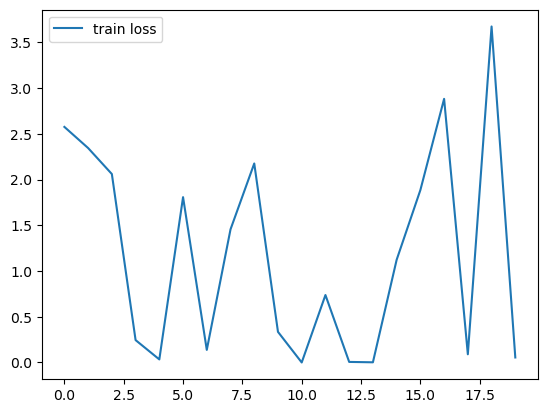

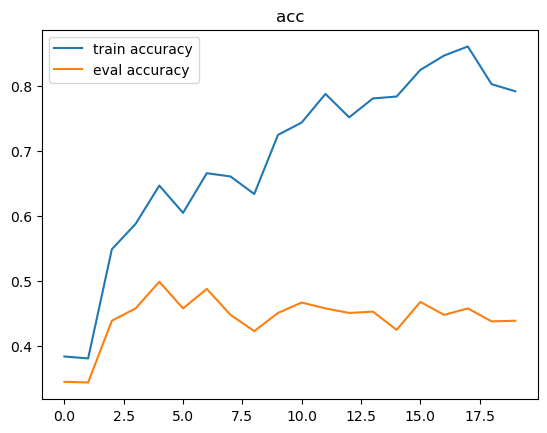

In [43]:
# run training and
model = main()

# TODO: save the model
st = model.state_dict()
torch.save(st, 'model.pt')

In [46]:
model
state_dict = torch.load('model.pt')
net_new = CNN()

In [47]:
net_new.load_state_dict(state_dict)

<All keys matched successfully>